### Code to generate Figure 3 - Haplogroup networks

In [1]:
%run setup.ipynb
%matplotlib inline
import hapclust
import pickle
import matplotlib.patches as patches

#### setup data

In [2]:
# obtain data from unphased callset - only needed for variant annotations
callset = phase1_ar31.callset
pos_all = allel.SortedIndex(callset['2L/variants/POS'])
ann_all = callset['2L/variants/ANN'][:][['Annotation', 'HGVS_p']]

# setup haplotype data
callset_phased = phase1_ar31.callset_phased
genotypes_phased = allel.GenotypeDaskArray(callset_phased['2L/calldata/genotype'])
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])
genotypes_phased.shape, pos_phased.shape

((8296600, 773, 2), (8296600,))

In [3]:
pos_kdr_s = 2422651
pos_kdr_f = 2422652

In [4]:
# define region we're going to analyse
loc_region = pos_phased.locate_range(0, 4000000)
pos_phased_region = pos_phased[loc_region]
pos_phased_region

0,1,2,3,4,...,163958,163959,163960,163961,163962
44688,44691,44732,44736,44756,...,3997372,3997373,3997378,3997381,3997386


In [5]:
# chop genotypes to region, remove colony parents (8 samples) and turn into haplotype array
gen_phased_region = genotypes_phased[loc_region][:, :-8].compute()
gen_phased_region.shape
# don't turn in .to_haplotypes() yet - might be easier to interleave new positions first, then turn whole lot into hap

(163963, 765, 2)

#### grab mvncalls

In [6]:
#genotypes
mvn_200 = np.load('../data/phasing_extra_phase1.mvncall.200.npz')
call_mvn = mvn_200['calldata']
gen_mvn = allel.GenotypeArray(call_mvn['genotype'])

#positions
pos_mvn = allel.SortedIndex(mvn_200['variants']['POS'])
pos_mvn

0,1,2
2391228,2400071,2429745


#### weave

In [7]:
#concatenate old and new gen/pos arrays
haps_combined = np.concatenate([gen_phased_region, gen_mvn], axis=0)
pos_combined = np.concatenate([pos_phased_region, pos_mvn], axis=0)

#sort pos indices
idx_sorted =np.argsort(pos_combined)

#use sorted indices to re-order the combined arrays
haps_combined = allel.GenotypeArray(haps_combined[idx_sorted])

pos_combined = allel.SortedIndex(pos_combined[idx_sorted])

#then turn into haplotype array...
haps = haps_combined.to_haplotypes()
haps

<HaplotypeArray shape=(163966, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

#### chop haps to just gene

In [8]:
region_vgsc = SeqFeature('2L', 2358158, 2431617)
loc = pos_combined.locate_range(region_vgsc.start, region_vgsc.end)
h_vgsc = haps[loc]

In [9]:
pos = pos_combined[loc]
pos_995S = 2422651
pos_995F = 2422652

sample_ids = callset['2L']['samples'][:]
hap_ids = np.array(list(itertools.chain(*[[s + b'a', s + b'b'] for s in sample_ids])))

tbl_haplotypes = etl.fromtsv('../data/ag1000g.phase1.AR3.1.haplotypes.meta.txt')
hap_pops = np.array(tbl_haplotypes.values('population'))

# need to use named colors for graphviz
pop_colors = {
    'AOM': 'brown',
    'BFM': 'firebrick1',
    'GWA': 'goldenrod1',
    'GNS': 'cadetblue1',
    'BFS': 'deepskyblue',
    'CMS': 'dodgerblue3',
    'UGS': 'palegreen',
    'GAS': 'olivedrab',
    'KES': 'grey47',
    'colony': 'black'
}
hap_colors = np.array([pop_colors[p] for p in hap_pops])

In [10]:
#associates pop colours with haps
hap_colors = np.array([pop_colors[p] for p in hap_pops])

#haplogroup indices generated in Figure_1a_Clado_SM.ipynb
with open('../data/clust_dict.pickle', 'rb') as handle:
    clus_dict = pickle.load(handle)

sorted(clus_dict.keys())

['F1', 'F2', 'F3', 'F4', 'F5', 'L1', 'L2', 'S1', 'S2', 'S3', 'S4/5']

#### add labels

In [11]:
tbl_variant_labels = (
    etl
    .frompickle('../data/tbl_variants_phase1.pkl')
    .eq('num_alleles', 2)
    .cut('POS', 'AGAP004707-RA')
    .convert('AGAP004707-RA', lambda v: v[1] if v[0] == 'NON_SYNONYMOUS_CODING' else '')
    .rename('AGAP004707-RA', 'label')
)
tbl_variant_labels

0|POS,1|label
2358254,D33N
2358316,
2358328,
2358353,
2358405,


In [12]:
pos2label = tbl_variant_labels.lookupone('POS', 'label')
pos2label[pos_995F]

'L995F'

In [13]:
variant_labels_vgsc= np.array([pos2label.get(p, '') for p in pos], dtype=object)
#variant_labels_vgsc = variant_labels[loc]
variant_labels_vgsc

array(['D33N', '', '', ..., '', '', ''], dtype=object)

## PRODUCE INDIVIDUAL NETWORK PLOTS
- remove recombinants
- leave F3 till last, multiallelics here mean that we need to use the pre-mvn-weave haplotypes

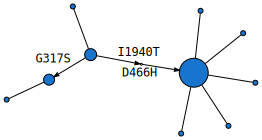

In [14]:
clus = 'F3' #without recomb
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps[:, idx_norec], hap_colors=cluster_hap_colors[idx_norec], mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_norecomb_t_hat'
graph16.render(fn)

graph16

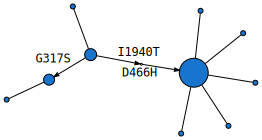

In [15]:
clus = 'F3' #without recomb
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_recomb_t_hat'
graph16.render(fn)

graph16

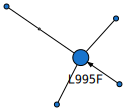

In [16]:
clus = 'F2'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps[:, idx_norec], hap_colors=cluster_hap_colors[idx_norec], mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_norecomb_t_hat'
graph16.render(fn)

graph16

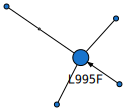

In [17]:
clus = 'F2'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_recomb_t_hat'
graph16.render(fn)

graph16

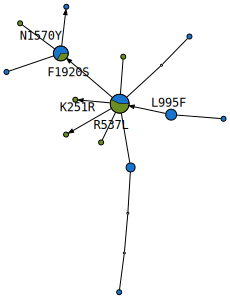

In [18]:
clus = 'F4'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps[:, idx_norec], hap_colors=cluster_hap_colors[idx_norec], mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_norecomb_t_hat'
graph16.render(fn)

graph16

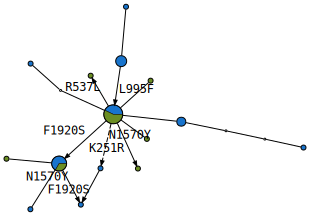

In [19]:
clus = 'F4'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_recomb_t_hat'
graph16.render(fn)

graph16

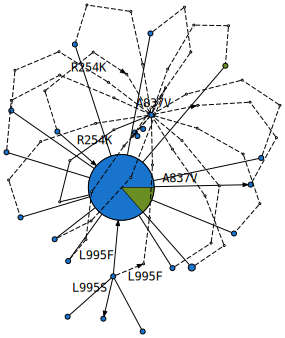

In [20]:
clus = 'F5'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps[:, idx_norec], hap_colors=cluster_hap_colors[idx_norec], mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_norecomb_t_hat'
graph16.render(fn)

graph16

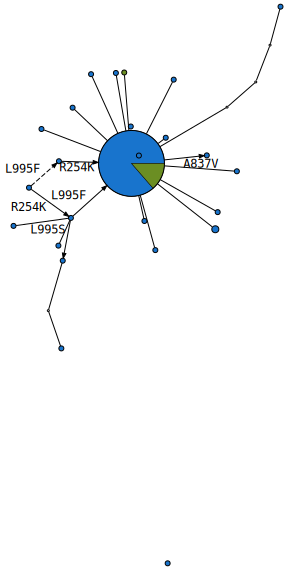

In [21]:
#using locate recomb here does terrifying things...

clus = 'F5'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK',
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_recomb_t_hat'
graph16.render(fn)

graph16

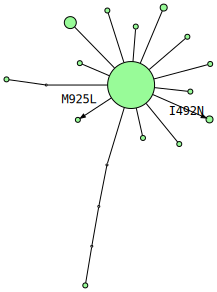

In [22]:
clus = 'S1'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps[:, idx_norec], hap_colors=cluster_hap_colors[idx_norec], mode='KK',
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_norecomb_t_hat'
graph16.render(fn)

graph16

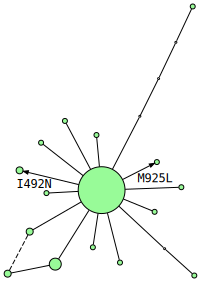

In [23]:
clus = 'S1'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK',
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_recomb_t_hat'
graph16.render(fn)

graph16

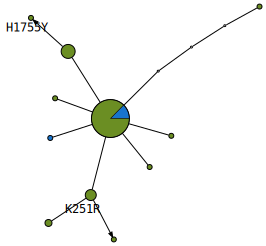

In [24]:
clus = 'S2'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps[:, idx_norec], hap_colors=cluster_hap_colors[idx_norec], mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=8)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_norecomb_t_hat'
graph16.render(fn)

graph16

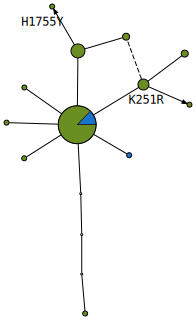

In [25]:
clus = 'S2'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK',
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_recomb_t_hat'
graph16.render(fn)

graph16

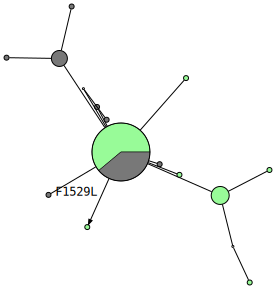

In [26]:
clus = 'S3'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps[:, idx_norec], hap_colors=cluster_hap_colors[idx_norec], mode='KK',
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_norecomb_t_hat'
graph16.render(fn)

graph16

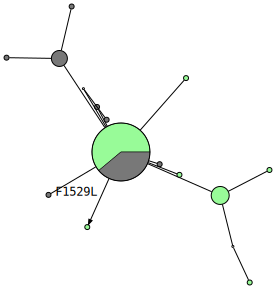

In [27]:
clus = 'S3'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK',
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_recomb_t_hat'
graph16.render(fn)

graph16

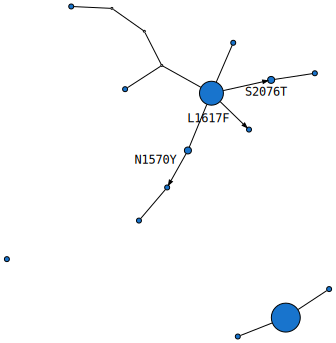

In [28]:
clus = 'S4/5'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps[:, idx_norec], hap_colors=cluster_hap_colors[idx_norec], mode='KK',
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_norecomb_t_hat'
graph16.render(fn)

graph16

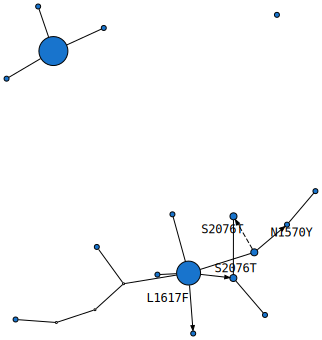

In [29]:
clus = 'S4/5'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_recomb_t_hat'
graph16.render(fn)

graph16

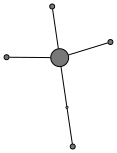

In [30]:
clus = 'L1'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps[:, idx_norec], hap_colors=cluster_hap_colors[idx_norec], mode='KK',
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_norecomb_t_hat'
graph16.render(fn)

graph16

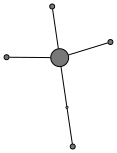

In [31]:
clus = 'L1'
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])


graph16 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_recomb_t_hat'
graph16.render(fn)

graph16

# BOTH L2 and F3 need the multiallelics removed...

In [32]:
#pre mvn call genotypes
gen_phased_region.shape

(163963, 765, 2)

In [33]:
#then turn into 'sp' haplotype array...
haps_sp = gen_phased_region.to_haplotypes()
haps_sp

<HaplotypeArray shape=(163963, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [64]:
loc_sp = pos_phased_region.locate_range(region_vgsc.start, region_vgsc.end)
h_vgsc_sp = haps_sp[loc]

In [65]:
h_vgsc_sp

<HaplotypeArray shape=(1713, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
1 1 0 1 1 ... 1 1 1 1 1
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [35]:
pos_sp = pos_phased_region[loc]
len(pos_sp), len(h_vgsc_sp)

(1713, 1713)

In [63]:
h_vgsc_sp.max()

1

In [70]:
clus = 'F1' #without recomb
cluster_idx = clus_dict[clus]
cluster_haps = h_vgsc_sp.take(list(cluster_idx), axis=1)
cluster_hap_pops = hap_pops[list(cluster_idx)]

#remove recombinants
# idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

# idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]

In [71]:
jasfkjjdflkj

NameError: name 'jasfkjjdflkj' is not defined

In [74]:
cluster_hap_pops.shape, cluster_haps.shape

((456,), (1713, 456))

In [61]:
idx_rec = hapclust.locate_recombinants(cluster_haps, debug=False)

In [ ]:
idx_norec = [i for i in range(cluster_haps.shape[1]) if i not in idx_rec[0]]

In [ ]:
cluster_haps

In [ ]:
h[:, idx_norec]

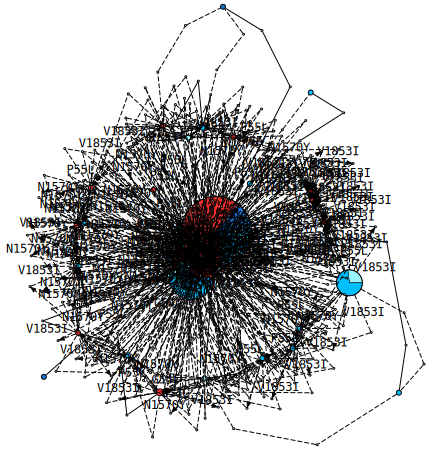

In [59]:
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
#[:, idx_norec]

graph16 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='msn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/'+clus+'_norecomb_t_hat'
graph16.render(fn)

graph16

# OLD HAPLOGROUP NETWORKS

In [ ]:
#check what the cluster nets looks like in mjn
#generate a 'graph'
#cluster_idx = 16
cluster_idx = clus_dict['F1']

#dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]


cluster_haps = h_vgsc.take(list(cluster_idx), axis=1)


cluster_hap_pops = hap_pops[list(cluster_idx)]


cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])

graph16 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)
graph16

graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995F_cluster_F1_mjn'
graph16.render(fn)

graph16

In [ ]:
cluster_idx = 12
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph12 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph12.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995F_cluster_12_mjn'
graph12.render(fn)

graph12

In [ ]:
cluster_idx = 8
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph8 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                          network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                          show_node_labels=10000, fontsize='12', 
                                          variant_labels=variant_labels_vgsc, max_dist=4)

graph8.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995F_cluster_8_mjn'
graph8.render(fn)

graph8

In [ ]:
cluster_idx = 7
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph7 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                          network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                          show_node_labels=10000, fontsize='12', 
                                          variant_labels=variant_labels_vgsc, max_dist=4)

graph7.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995F_cluster_7_mjn'
graph7.render(fn)

graph7

In [ ]:
cluster_idx = 4
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph4 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                 network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                 show_node_labels=10000, fontsize='12', 
                                 variant_labels=variant_labels_vgsc, max_dist=4)

graph4.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995F_cluster_4_mjn'
graph4.render(fn)

graph4

- 995S

In [ ]:
cluster_idx = 17
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph17 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)
graph17

graph17.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995S_cluster_17_mjn'
graph17.render(fn)

graph17

In [ ]:
cluster_idx = 14
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph14 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)
graph14

graph14.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995S_cluster_14_mjn'
graph14.render(fn)

graph14

In [ ]:
cluster_idx = 12
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph12 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)
graph12

graph12.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995S_cluster_12_mjn'
graph12.render(fn)

graph12

In [ ]:
cluster_idx = 9
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph9 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)
graph9

graph9.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995S_cluster_12_mjn'
graph9.render(fn)

graph9

In [ ]:
cluster_idx = 2
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph2 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)
graph2

graph2.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995S_cluster_2_mjn'
graph2.render(fn)

graph2